In [1]:
import evaluator_prob as evaluator
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit import QuantumCircuit
from qiskit.transpiler.passes import NoiseAdaptiveLayout
from qcg.generators import gen_supremacy, gen_hwea
from qiskit import Aer, IBMQ, execute
from qiskit.converters import circuit_to_dag, dag_to_circuit
from scipy.stats import wasserstein_distance
from qiskit.providers.aer import noise
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram

circ = gen_supremacy(2,3,8,order='75601234')

num_shots = int(1e4)
provider = IBMQ.load_account()
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates
dag = circuit_to_dag(circ)
noise_mapper = NoiseAdaptiveLayout(properties)
noise_mapper.run(dag)
initial_layout = noise_mapper.property_set['layout']

ground_truth = evaluator.simulate_circ(circ=circ,backend='statevector_simulator',noisy=False,qasm_info=None)

qasm_info = [None,None,None,num_shots,None]
qasm_prob = evaluator.simulate_circ(circ=circ,backend='qasm_simulator',noisy=False,qasm_info=qasm_info)
qasm_distance = wasserstein_distance(ground_truth,qasm_prob)

qasm_info = [noise_model,coupling_map,basis_gates,num_shots,None]
qasm_noise_prob = evaluator.simulate_circ(circ=circ,backend='qasm_simulator',noisy=True,qasm_info=qasm_info)
qasm_noise_distance = wasserstein_distance(ground_truth,qasm_noise_prob)

qasm_info = [noise_model,coupling_map,basis_gates,num_shots,initial_layout]
qasm_noise_na_prob = evaluator.simulate_circ(circ=circ,backend='qasm_simulator',noisy=True,qasm_info=qasm_info)
qasm_noise_na_distance = wasserstein_distance(ground_truth,qasm_noise_na_prob)

print('qasm_distance =',qasm_distance,'qasm_noise_distance =',qasm_noise_distance,'qasm_noise_na_distance =',qasm_noise_na_distance)

qasm_distance = 0.0008514752903720422 qasm_noise_distance = 0.010321385692263367 qasm_noise_na_distance = 0.005867214921637589


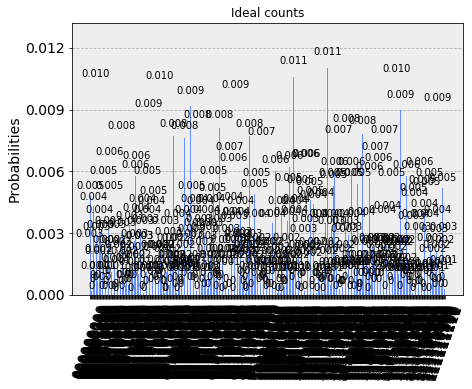

In [2]:
plot_histogram(noiseless_counts, title='Ideal counts')

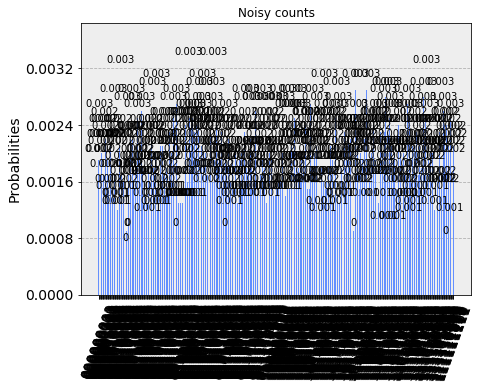

In [3]:
plot_histogram(noisy_counts, title='Noisy counts')

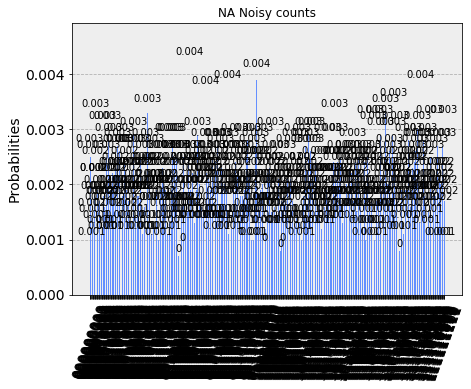

In [4]:
plot_histogram(na_counts, title='NA Noisy counts')